# 데이터 정보

| **변수명**         | **설명**                         |**상세 설명**|
|--------------------|----------------------------------|-----------------|
| bus_no             | 셔틀 버스 노선                   |?호차|
| now_stop_name      | 현재 정류장 이름                 ||
| now_stop_lat       | 현재 정류장 위도                 ||
| now_stop_long      | 현재 정류장 경도                 ||
| next_stop_name     | 다음 정류장 이름                 ||
| next_stop_lat      | 다음 정류장 위도                 ||
| next_stop_long     | 다음 정류장 경도                 ||
| distance           | 현재 정류장 부터 다음 정류장 까지 거리 |단위 km|
| weather            | 날씨                             |0: 맑음, 11 안개 낌, 23 비 강, 22 비 중, 21 비약, 33 눈강, 32 눈 중, 31 눈 약|
| time               | 현재 정류장에서 다음 정류장 까지 걸린 시간      |단위: 분|
| date               | 날짜                             |yyyy-mm-dd|


# 데이터 수집
교육 시작한 날인 24년 1월 2일 부터 현재(24년 7월 27일) 데이터를 사용했습니다.

셔틀버스 노선은 제공 받은 자료를 사용했고, 셔틀버스 경로는 직접 조사를 했습니다.

날씨 데이터는 기상청 API를 이용했습니다.

시간 데이터는 대전 교통 빅데이터 플랫폼(https://tportal.daejeon.go.kr/) 사이트에서 셔틀이 지나가는 구간 별 속도를 통해 현재 정류장에서 다음 정류장 까지의 시간을 구했습니다

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import csv
import re

In [4]:
# 셔틀 버스 정류장 정보
bus_routes = {
    1: [
        ("오정동 육교 밑(국민연금북대전지사)", 36.358602, 127.412893, 2.2),
        ("오정동 육교 밑(국민연금북대전지사)", 36.358602, 127.412893, 2.2),
        ("재뜰네거리(샘머리A부근)", 36.358013, 127.395171, 1.2),
        ("정부청사 4번출구 앞", 36.357934, 127.381689, 0.9),
        ("갈마역", 36.357907, 127.372136, 0.9),
        ("월평역 버스정류장(이마트 트레이더스 맞은편)", 36.358705, 127.362427, 1.8),
        ("GS 충대 앞 주유소", 36.361253, 127.344114, 0.5),
        ("유성문화원", 36.360070, 127.341169, 4.8)
    ],
    2: [
        ("송강전통시장 버스정류장", 36.435520, 127.387100, 1.0),
        ("롯데마트 맞은편 데이편의점", 36.427262, 127.385392, 5.1),
        ("연구단지 네거리 (대덕고등학고 버스정류장)", 36.386534, 127.378574, 3.9),
        ("유성구청 앞 버스정류장", 36.361356, 127.356039, 0.6),
        ("큰맘할매순대국(충남대점)", 36.360798, 127.349439, 1.0),
        ("학사마을", 36.362206, 127.345455, 2.5),
        ("월드컵경기장역 3번출구", 36.367067, 127.317019, 2.5)
    ],
    3: [
        ("도마네거리", 36.312587, 127.378663, 3.2),
        ("가수원네거리", 36.305639, 127.353240, 1.6),
        ("수목토아파트", 36.318523, 127.347960, 4.5),
        ("유성온천역 5번출구 맥도날드", 36.354189, 127.340262, 4.7)
    ],
    4: [
        ("동춘당 맞은편 버스정류장", 36.364762, 127.440370, 2.8),
        ("용전네거리", 36.346920, 127.431126, 1.3),
        ("국민건강보험공단 대전동부지사", 36.339839, 127.419931, 2.8),
        ("오룡역 3번출구(보람상조 앞)", 36.328473, 127.404348, 1.0),
        ("태평오거리(모카라이팅)", 36.326103, 127.394357, 1.3),
        ("가장네거리(맑은 아침 버스정류장)", 36.330370, 127.383093, 1.1),
        ("서중학교 버스 정류장", 36.333100, 127.373657, 3.5),
        ("원신흥동 기아 도안지점", 36.332426, 127.340248, 5.7),
        ("덕명중학교 정문", 36.345647, 127.301785, 0.5),
        ("한밭대 뚜레주르", 36.348556, 127.298218, 1.0)
    ],
    5: [
        ("반석역 1번출구", 36.391559, 127.314786, 1.0),
        ("지족역 2번출구", 36.383758, 127.319905, 1.1),
        ("노은역 1번출구", 36.373557, 127.317724, 4.3),
        ("유성온천역 5번출구 맥도날드", 36.354189, 127.340262, 0.6),
        ("봉명네거리승강장", 36.355626, 127.334724, 4.1)
    ],
    6: [
        ("대전시청 버스승강장", 36.351222, 127.385137, 1.0),
        ("탄방중학교 버스승강장", 36.350387, 127.395124, 0.6),
        ("한양공작아파트 버스승강장", 36.346771, 127.393179, 1.0),
        ("경성큰마을 삼거리", 36.346172, 127.378942, 1.6),
        ("갈마삼거리 육교", 36.351349, 127.371854, 1.3),
        ("유성온천역 5번출구 맥도날드", 36.354189, 127.340262, 3.9),
        ("현충원역", 36.359471, 127.320104, 2.1)
    ]
}

# 날짜 생성
start_date = pd.to_datetime("2024-01-02")
end_date = pd.to_datetime("2024-07-27")
date_range = pd.date_range(start_date, end_date)

# 초기 데이터 프레임 생성
data = {
    "bus_no": [],
    "now_stop_name": [],
    "now_stop_lat": [],
    "now_stop_long": [],
    "next_stop_name": [],
    "next_stop_lat": [],
    "next_stop_long": [],
    "distance": [],
    "weather": [],
    "time": [],
    "date": [],
    "day": []
}

# 데이터 채우기
for bus_no, stops in bus_routes.items():
    for single_date in date_range:
        for i in range(len(stops) - 1):
            now_stop = stops[i]
            next_stop = stops[i + 1]
            
            data["bus_no"].append(bus_no)
            data["now_stop_name"].append(now_stop[0])
            data["now_stop_lat"].append(now_stop[1])
            data["now_stop_long"].append(now_stop[2])
            data["next_stop_name"].append(next_stop[0])
            data["next_stop_lat"].append(next_stop[1])
            data["next_stop_long"].append(next_stop[2])
            data["distance"].append(now_stop[3])
            data["weather"].append(np.nan)
            data["time"].append(np.nan)
            data["date"].append(single_date.strftime("%Y-%m-%d"))
            data["day"].append(single_date.strftime("%A"))

# 데이터 프레임 생성
df = pd.DataFrame(data)

# 결과 출력
df

# 기본 데이터 완료

,bus_no,now_stop_name,now_stop_lat,now_stop_long,next_stop_name,next_stop_lat,next_stop_long,distance,weather,time,date,day
0,1,오정동 육교 밑(국민연금북대전지사),36.358602,127.412893,재뜰네거리(샘머리A부근),36.358013,127.395171,2.2,NaN,NaN,2024-01-02,Tuesday
1,1,재뜰네거리(샘머리A부근),36.358013,127.395171,정부청사 4번출구 앞,36.357934,127.381689,1.2,NaN,NaN,2024-01-02,Tuesday
2,1,정부청사 4번출구 앞,36.357934,127.381689,갈마역,36.357907,127.372136,0.9,NaN,NaN,2024-01-02,Tuesday
3,1,갈마역,36.357907,127.372136,월평역 버스정류장(이마트 트레이더스 맞은편),36.358705,127.362427,0.9,NaN,NaN,2024-01-02,Tuesday
4,1,월평역 버스정류장(이마트 트레이더스 맞은편),36.358705,127.362427,GS 충대 앞 주유소,36.361253,127.344114,1.8,NaN,NaN,2024-01-02,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...
7067,6,탄방중학교 버스승강장,36.350387,127.395124,한양공작아파트 버스승강장,36.346771,127.393179,0.6,NaN,NaN,2024-07-27,Saturday
7068,6,한양공작아파트 버스승강장,36.346771,127.393179,경성큰마을 삼거리,36.346172,127.378942,1.0,NaN,NaN,2024-07-27,Saturday
7069,6,경성큰마을 삼거리,36.346172,127.378942,갈마삼거리 육교,36.351349,127.371854,1.6,NaN,NaN,2024-07-27,Saturday
7070,6,갈마삼거리 육교,36.351349,127.371854,유성온천역 5번출구 맥도날드,36.354189,127.340262,1.3,NaN,NaN,2024-07-27,Saturday


In [5]:
# 평일만 가니까 주말 데이터 삭제
# 'Saturday'와 'Sunday'인 행 제거
df_filtered = df[~df['day'].isin(['Saturday', 'Sunday'])]
df_filtered

,bus_no,now_stop_name,now_stop_lat,now_stop_long,next_stop_name,next_stop_lat,next_stop_long,distance,weather,time,date,day
0,1,오정동 육교 밑(국민연금북대전지사),36.358602,127.412893,재뜰네거리(샘머리A부근),36.358013,127.395171,2.2,NaN,NaN,2024-01-02,Tuesday
1,1,재뜰네거리(샘머리A부근),36.358013,127.395171,정부청사 4번출구 앞,36.357934,127.381689,1.2,NaN,NaN,2024-01-02,Tuesday
2,1,정부청사 4번출구 앞,36.357934,127.381689,갈마역,36.357907,127.372136,0.9,NaN,NaN,2024-01-02,Tuesday
3,1,갈마역,36.357907,127.372136,월평역 버스정류장(이마트 트레이더스 맞은편),36.358705,127.362427,0.9,NaN,NaN,2024-01-02,Tuesday
4,1,월평역 버스정류장(이마트 트레이더스 맞은편),36.358705,127.362427,GS 충대 앞 주유소,36.361253,127.344114,1.8,NaN,NaN,2024-01-02,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...
7061,6,탄방중학교 버스승강장,36.350387,127.395124,한양공작아파트 버스승강장,36.346771,127.393179,0.6,NaN,NaN,2024-07-26,Friday
7062,6,한양공작아파트 버스승강장,36.346771,127.393179,경성큰마을 삼거리,36.346172,127.378942,1.0,NaN,NaN,2024-07-26,Friday
7063,6,경성큰마을 삼거리,36.346172,127.378942,갈마삼거리 육교,36.351349,127.371854,1.6,NaN,NaN,2024-07-26,Friday
7064,6,갈마삼거리 육교,36.351349,127.371854,유성온천역 5번출구 맥도날드,36.354189,127.340262,1.3,NaN,NaN,2024-07-26,Friday


In [6]:
# 공휴일 리스트
holidays = [
    "2024-02-09", "2024-02-10", "2024-02-11", # 설날 연휴
    "2024-03-01", # 삼일절
    "2024-04-10", # 국회의원 선거일
    "2024-05-05", "2024-05-06", # 어린이날 및 대체공휴일
    "2024-06-06", # 현충일
]

# 공휴일과 특정 날짜 범위를 제거
df_filtered = df_filtered[~df_filtered['date'].isin(holidays)]
df_filtered = df_filtered[~df_filtered['date'].between("2024-05-27", "2024-07-01")] # 잡 페어 기간 제거

# 결과 출력
df_filtered.tail()

,bus_no,now_stop_name,now_stop_lat,now_stop_long,next_stop_name,next_stop_lat,next_stop_long,distance,weather,time,date,day
7061,6,탄방중학교 버스승강장,36.350387,127.395124,한양공작아파트 버스승강장,36.346771,127.393179,0.6,NaN,NaN,2024-07-26,Friday
7062,6,한양공작아파트 버스승강장,36.346771,127.393179,경성큰마을 삼거리,36.346172,127.378942,1.0,NaN,NaN,2024-07-26,Friday
7063,6,경성큰마을 삼거리,36.346172,127.378942,갈마삼거리 육교,36.351349,127.371854,1.6,NaN,NaN,2024-07-26,Friday
7064,6,갈마삼거리 육교,36.351349,127.371854,유성온천역 5번출구 맥도날드,36.354189,127.340262,1.3,NaN,NaN,2024-07-26,Friday
7065,6,유성온천역 5번출구 맥도날드,36.354189,127.340262,현충원역,36.359471,127.320104,3.9,NaN,NaN,2024-07-26,Friday


In [14]:
# URL과 저장 경로 변수를 지정합니다.
url = 'https://apihub.kma.go.kr/api/typ01/url/kma_sfcdd3.php?tm1=20240102&tm2=20240727&stn=133&help=1&mode=0&authKey='
# url = 'https://apihub.kma.go.kr/api/typ01/url/kma_sfcdd3.php?tm1=20240102&tm2=20240727&stn=133&help=0&mode=0&authKey=' 데이터 설명 없는 API

response = requests.get(url)
response_text = response.text

# 텍스트 응답을 JSON으로 변환
try:
    json_response = json.loads(response_text)
    print(json_response)
except json.JSONDecodeError as e:
    print(f"JSON decode error: {e}")
    print(response_text)


JSON decode error: Expecting value: line 1 column 1 (char 0)
#START7777
#--------------------------------------------------------------------------------------------------
#  기상청 지상관측 일자료 [입력인수형태][예] ?tm=20100715&stn=0&help=1
#--------------------------------------------------------------------------------------------------
#  1. TM            : 관측일 (KST)
#  2. STN           : 국내 지점번호
#  3. WS_AVG        : 일 평균 풍속 (m/s)
#  4. WR_DAY        : 일 풍정 (m)
#  5. WD_MAX        : 최대풍향
#  6. WS_MAX        : 최대풍속 (m/s)
#  7. WS_MAX_TM     : 최대풍속 시각 (시분)
#  8. WD_INS        : 최대순간풍향
#  9. WS_INS        : 최대순간풍속 (m/s)
# 10. WS_INS_TM     : 최대순간풍속 시각 (시분)
# 11. TA_AVG        : 일 평균기온 (C)
# 12. TA_MAX        : 최고기온 (C)
# 13. TA_MAX_TM     : 최고기온 시가 (시분)
# 14. TA_MIN        : 최저기온 (C)
# 15. TA_MIN_TM     : 최저기온 시각 (시분)
# 16. TD_AVG        : 일 평균 이슬점온도 (C)
# 17. TS_AVG        : 일 평균 지면온도 (C)
# 18. TG_MIN        : 일 최저 초상온도 (C)
# 19. HM_AVG        : 일 평균 상대습도 (%)
# 20. HM_MIN        : 최저습도 (%)
# 21. HM

In [18]:
response = requests.get(url)

response_text = response.text

# 텍스트 응답을 JSON으로 변환
try:
    json_response = json.loads(response_text)
    print(json_response)
except json.JSONDecodeError as e:
    print(f"JSON decode error: {e}")
    print(response_text)

JSON decode error: Expecting value: line 1 column 1 (char 0)
#START7777
#2345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123
# YYMMDD STN   WS    WR  WD   WS   WS  WD   WS   WS    TA    TA   TA    TA   TA    TD    TS    TG    HM    HM   HM    PV  EV_S  EV_L    FG     PA     PS     PS   PS     PS   PS   CA   SS   SS   SS    SI    SI   SI     RN     RN    RN     RN   RN     RN   RN     RN   RN     SD   SD     SD   SD    TE    TE    TE    TE    TE
#    KST  ID  AVG   DAY MAX  MAX  MAX INS  INS  INS   AVG   MAX  MAX   MIN  MIN   AVG   AVG   MIN   AVG   MIN  MIN   AVG               DUR    AVG    AVG    MAX  MAX    MIN  MIN  TOT  DAY  DUR  CMB   DAY   60M  60M    DAY    D99   DUR    60M  60M    10M  10M    POW  POW    NEW  NE

In [20]:
# response_text에서 데이터 부분 추출
data_lines = response_text.split('\n')
start_index = 0
end_index = 0

for i, line in enumerate(data_lines):
    if '#START7777' in line:
        start_index = i + 4
    elif '#7777END' in line:
        end_index = i
        break

# 데이터 추출
data_lines = data_lines[start_index:end_index]

# 헤더 추출
header_line = data_lines[0].strip('#').split()
data_lines = data_lines[1:]

# CSV 파일로 저장
csv_filename = 'weather_data.csv'

with open(csv_filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(header_line)
    for line in data_lines:
        row = re.split(r'\s+', line.strip())
        csvwriter.writerow(row)

print(f"Data saved to {csv_filename}")

Data saved to weather_data.csv


In [7]:
# 날씨 데이터 전 처리
weather_data = pd.read_csv('./weather_data.csv')

weather_data.head()

,TM,STN,WS_AVG,WR_DAY,WD_MAX,WS_MAX,WS_MAX_TM,WD_INS,WS_INS,WS_INS_TM,...,RN_POW_MAX_TM,SD_NEW,SD_NEW_TM,SD_MAX,SD_MAX_TM,TE_05,TE_10,TE_15,TE_30,TE_50
0,20240102,133,1.3,1130,32,3.3,1509,34,7.0,1502,...,-9,-9.0,-9,-9.0,-9,6.4,8.4,10.5,16.2,19.1
1,20240103,133,1.3,1148,32,4.7,1855,34,9.1,1851,...,-9,-9.0,-9,-9.0,-9,6.5,8.5,10.5,16.1,19.0
2,20240104,133,1.1,928,20,3.7,1445,20,6.3,1429,...,-9,-9.0,-9,-9.0,-9,6.0,8.5,10.5,16.0,18.9
3,20240105,133,1.7,1436,32,4.2,2216,34,6.8,2211,...,-9,-9.0,-9,-9.0,-9,5.9,8.6,10.5,16.0,19.0
4,20240106,133,1.9,1633,32,4.0,1348,34,6.7,1343,...,-9,1.4,2255,1.4,2255,5.9,8.5,10.5,15.8,18.9


In [8]:
weather_data.columns

Index(['TM', 'STN', 'WS_AVG', 'WR_DAY', 'WD_MAX', 'WS_MAX', 'WS_MAX_TM',
       'WD_INS', 'WS_INS', 'WS_INS_TM', 'TA_AVG', 'TA_MAX', 'TA_MIN_TM',
       'TA_MIN', 'TA_MIN_TM.1', 'TD_AVG', 'TS_AVG', 'TG_MIN', 'HM_AVG',
       'HM_MIN', 'HM_MIN_TM', 'PV_AVG', 'EV_S', 'EV_L', 'FG_DUR', 'PA_AVG',
       'PS_AVG', 'PS_MAX', 'PS_MAX_TM', 'PS_MIN', 'PS_MIN_TM', 'CA_TOT',
       'SS_DAY', 'SS_DUR', 'SS_CMB', 'SI_DAY', 'SI_60M_MAX', 'SI_60M_MAX_TM',
       'RN_DAY', 'RN_D99', 'RN_DUR', 'RN_60M_MAX', 'RN_60M_MAX_TM',
       'RN_10M_MAX ', 'RN_10M_MAX_TM', 'RN_POW_MAX', 'RN_POW_MAX_TM', 'SD_NEW',
       'SD_NEW_TM', 'SD_MAX', 'SD_MAX_TM', 'TE_05', 'TE_10', 'TE_15', 'TE_30',
       'TE_50'],
      dtype='object')

In [9]:
# 필요없는 데이터 삭제
#2,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,26,27,28,29,30,31,32,33,34,35,36,37,38,40,41,42,43,44,45,47,48,49,51,52,53,54,55,56
# 삭제할 열 인덱스 목록
columns_to_delete = [1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38 ,39, 40, 42, 43, 44, 46, 47, 48, 50, 51, 52, 53, 54, 55]

# 인덱스 번호로 삭제할 열 이름 가져오기
columns_to_delete_names = weather_data.columns[columns_to_delete]

# 지정된 열 삭제
weather_data_filter = weather_data.drop(columns=columns_to_delete_names, axis=1)

weather_data_filter

,TM,WS_AVG,TA_AVG,FG_DUR,RN_60M_MAX,RN_POW_MAX,SD_MAX
0,20240102,1.3,4.0,-9.0,-9.0,-9,-9.0
1,20240103,1.3,1.9,-9.0,-9.0,-9,-9.0
2,20240104,1.1,1.0,-9.0,-9.0,-9,-9.0
3,20240105,1.7,5.6,-9.0,-9.0,-9,-9.0
4,20240106,1.9,1.4,-9.0,-9.0,-9,1.4
...,...,...,...,...,...,...,...
203,20240723,2.2,27.2,-9.0,2.5,-9,-9.0
204,20240724,1.5,28.6,-9.0,2.5,-9,-9.0
205,20240725,1.1,28.1,-9.0,0.1,-9,-9.0
206,20240726,2.0,28.4,-9.0,1.0,-9,-9.0


In [10]:
# -9인 값 0으로 바꾸기 
# -9는 아무일도 아닌 날
weather_data_filter.replace([-1, -9.0], 0, inplace=True)

weather_data_filter

# TM : 관측일
# WS_AVG: 일 평균 풍속
# TA_AVG: 일 평균 기온
# FG_DUR: 안개계속시간
# RN_60M_MAX: 1시간 강수량
# SD_MAX:최심 적설

,TM,WS_AVG,TA_AVG,FG_DUR,RN_60M_MAX,RN_POW_MAX,SD_MAX
0,20240102,1.3,4.0,0.0,0.0,0,0.0
1,20240103,1.3,1.9,0.0,0.0,0,0.0
2,20240104,1.1,1.0,0.0,0.0,0,0.0
3,20240105,1.7,5.6,0.0,0.0,0,0.0
4,20240106,1.9,1.4,0.0,0.0,0,1.4
...,...,...,...,...,...,...,...
203,20240723,2.2,27.2,0.0,2.5,0,0.0
204,20240724,1.5,28.6,0.0,2.5,0,0.0
205,20240725,1.1,28.1,0.0,0.1,0,0.0
206,20240726,2.0,28.4,0.0,1.0,0,0.0


In [11]:
# 날씨 코드로 만들어 주기
def get_weather_code(row):
    if row["FG_DUR"] >= 1.0:
        return "11"  # 안개 낌
    elif row["RN_60M_MAX"] >= 30:
        return "23"  # 비 강
    elif row["RN_60M_MAX"] >= 15:
        return "22"  # 비 중
    elif row["RN_60M_MAX"] >= 3:
        return "21"  # 비 약
    elif row["SD_MAX"] >= 20:
        return "33"  # 눈 강
    elif row["SD_MAX"] >= 10:
        return "32"  # 눈 중
    elif row["SD_MAX"] >= 5:
        return "31"  # 눈 약
    else:
        return "00"  # 맑음

weather_data_filter["기상 코드"] = weather_data_filter.apply(get_weather_code, axis=1)

new_df = weather_data_filter[["TM", "기상 코드"]]

new_df


,TM,기상 코드
0,20240102,00
1,20240103,00
2,20240104,00
3,20240105,00
4,20240106,00
...,...,...
203,20240723,00
204,20240724,00
205,20240725,00
206,20240726,00


In [12]:
# TM 날짜 형식으로 맞춰주기 교통 정보 df 랑 합치기 위해서
# TM 컬럼을 날짜 형식으로 변환
weather_data_filter["TM"] = pd.to_datetime(weather_data_filter["TM"], format='%Y%m%d').dt.strftime('%Y-%m-%d')

# 필요한 컬럼 선택
new_df = weather_data_filter[["TM", "기상 코드"]]

new_df


,TM,기상 코드
0,2024-01-02,00
1,2024-01-03,00
2,2024-01-04,00
3,2024-01-05,00
4,2024-01-06,00
...,...,...
203,2024-07-23,00
204,2024-07-24,00
205,2024-07-25,00
206,2024-07-26,00


In [13]:
# 두 데이터프레임 병합
merged_df = pd.merge(df_filtered, new_df, left_on='date', right_on='TM', how='left')

# weather 컬럼 업데이트
merged_df['weather'] = merged_df.apply(
    lambda row: row['기상 코드'] if pd.notnull(row['기상 코드']) else row['weather'], axis=1
)

# 결과에서 필요 없는 'TM' 컬럼 삭제
merged_df.drop(columns=['TM', '기상 코드'], inplace=True)

# 결과 출력
merged_df

,bus_no,now_stop_name,now_stop_lat,now_stop_long,next_stop_name,next_stop_lat,next_stop_long,distance,weather,time,date,day
0,1,오정동 육교 밑(국민연금북대전지사),36.358602,127.412893,재뜰네거리(샘머리A부근),36.358013,127.395171,2.2,00,NaN,2024-01-02,Tuesday
1,1,재뜰네거리(샘머리A부근),36.358013,127.395171,정부청사 4번출구 앞,36.357934,127.381689,1.2,00,NaN,2024-01-02,Tuesday
2,1,정부청사 4번출구 앞,36.357934,127.381689,갈마역,36.357907,127.372136,0.9,00,NaN,2024-01-02,Tuesday
3,1,갈마역,36.357907,127.372136,월평역 버스정류장(이마트 트레이더스 맞은편),36.358705,127.362427,0.9,00,NaN,2024-01-02,Tuesday
4,1,월평역 버스정류장(이마트 트레이더스 맞은편),36.358705,127.362427,GS 충대 앞 주유소,36.361253,127.344114,1.8,00,NaN,2024-01-02,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...
4041,6,탄방중학교 버스승강장,36.350387,127.395124,한양공작아파트 버스승강장,36.346771,127.393179,0.6,00,NaN,2024-07-26,Friday
4042,6,한양공작아파트 버스승강장,36.346771,127.393179,경성큰마을 삼거리,36.346172,127.378942,1.0,00,NaN,2024-07-26,Friday
4043,6,경성큰마을 삼거리,36.346172,127.378942,갈마삼거리 육교,36.351349,127.371854,1.6,00,NaN,2024-07-26,Friday
4044,6,갈마삼거리 육교,36.351349,127.371854,유성온천역 5번출구 맥도날드,36.354189,127.340262,1.3,00,NaN,2024-07-26,Friday


In [18]:
df = pd.read_csv('./final_data.csv', encoding='cp949')

df.head()

,bus_no,now_stop_name,now_stop_lat,now_stop_long,next_stop_name,next_stop_lat,next_stop_long,distance,weather,time,date,day
0,1,오정동 육교 밑(국민연금북대전지사),36.358602,127.412893,재뜰네거리(샘머리A부근),36.358013,127.395171,2.2,0,7,2024-01-02,Tuesday
1,1,재뜰네거리(샘머리A부근),36.358013,127.395171,정부청사 4번출구 앞,36.357934,127.381689,1.2,0,4,2024-01-02,Tuesday
2,1,정부청사 4번출구 앞,36.357934,127.381689,갈마역,36.357907,127.372136,0.9,0,5,2024-01-02,Tuesday
3,1,갈마역,36.357907,127.372136,월평역 버스정류장(이마트 트레이더스 맞은편),36.358705,127.362427,0.9,0,5,2024-01-02,Tuesday
4,1,월평역 버스정류장(이마트 트레이더스 맞은편),36.358705,127.362427,GS 충대 앞 주유소,36.361253,127.344114,1.8,0,6,2024-01-02,Tuesday


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bus_no          4046 non-null   int64  
 1   now_stop_name   4046 non-null   object 
 2   now_stop_lat    4046 non-null   float64
 3   now_stop_long   4046 non-null   float64
 4   next_stop_name  4046 non-null   object 
 5   next_stop_lat   4046 non-null   float64
 6   next_stop_long  4046 non-null   float64
 7   distance        4046 non-null   float64
 8   weather         4046 non-null   int64  
 9   time            4046 non-null   int64  
 10  date            4046 non-null   object 
 11  day             4046 non-null   object 
dtypes: float64(5), int64(3), object(4)
memory usage: 379.4+ KB


# 데이터 전처리

데이터 전처리: 모델 학습을 위해 필요한 데이터 전처리를 수행합니다. 예를 들어, 결측치 처리, 범주형 변수 인코딩 등을 포함할 수 있습니다.

모델 선택 및 학습: 다양한 머신러닝 모델을 선택하여 학습합니다. 예를 들어, 선형 회귀, 랜덤 포레스트, XGBoost 등을 시도할 수 있습니다.

모델 평가: 학습된 모델을 평가하고 최적의 모델을 선택합니다.

1. 결측치 처리 (Missing Values)
데이터 내 결측치가 있는 경우 이를 처리합니다. 결측치를 제거하거나, 평균/중앙값 등으로 대체할 수 있습니다.

2. 범주형 변수 인코딩 (Categorical Encoding)
범주형 변수를 수치형으로 변환합니다. 예를 들어, weather 변수를 원-핫 인코딩(One-Hot Encoding)으로 변환합니다.

3. 데이터 스케일링 (Scaling)
모델 학습을 위해 데이터의 스케일을 맞춥니다. 특히 거리, 위도, 경도 등의 변수는 표준화(Standardization)나 정규화(Normalization)가 필요할 수 있습니다.

4. 날짜 및 시간 처리 (Datetime Handling)
날짜 변수를 년, 월, 일, 요일 등으로 분리합니다.

5. 데이터 라벨링 


# 데이터 전처리

1. 결측치 처리

2. 범주형 변수 인코딩
범주형 변수 수치형으로 변경: weather 변수 원 핫 인코딩

3. 데이터 라벨링
요일 ,현재 정류장, 다음 정류장 데이터 라벨링


In [27]:
# ! pip install scikit-learn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
df = pd.read_csv('./final_data.csv', encoding='cp949')

df.head()

,bus_no,now_stop_name,now_stop_lat,now_stop_long,next_stop_name,next_stop_lat,next_stop_long,distance,weather,time,date,day
0,1,오정동 육교 밑(국민연금북대전지사),36.358602,127.412893,재뜰네거리(샘머리A부근),36.358013,127.395171,2.2,0,7,2024-01-02,Tuesday
1,1,재뜰네거리(샘머리A부근),36.358013,127.395171,정부청사 4번출구 앞,36.357934,127.381689,1.2,0,4,2024-01-02,Tuesday
2,1,정부청사 4번출구 앞,36.357934,127.381689,갈마역,36.357907,127.372136,0.9,0,5,2024-01-02,Tuesday
3,1,갈마역,36.357907,127.372136,월평역 버스정류장(이마트 트레이더스 맞은편),36.358705,127.362427,0.9,0,5,2024-01-02,Tuesday
4,1,월평역 버스정류장(이마트 트레이더스 맞은편),36.358705,127.362427,GS 충대 앞 주유소,36.361253,127.344114,1.8,0,6,2024-01-02,Tuesday


In [5]:
# 1. 결측치 처리
df.isna().sum()

bus_no            0
now_stop_name     0
now_stop_lat      0
now_stop_long     0
next_stop_name    0
next_stop_lat     0
next_stop_long    0
distance          0
weather           0
time              0
date              0
day               0
dtype: int64

In [33]:
# 범주형 변수 인코딩
data = pd.get_dummies(df, columns=['weather'], prefix='weather')

data.head()

,bus_no,now_stop_name,now_stop_lat,now_stop_long,next_stop_name,next_stop_lat,next_stop_long,distance,time,date,day,weather_0,weather_11,weather_21,weather_22,weather_23
0,1,오정동 육교 밑(국민연금북대전지사),36.358602,127.412893,재뜰네거리(샘머리A부근),36.358013,127.395171,2.2,7,2024-01-02,Tuesday,True,False,False,False,False
1,1,재뜰네거리(샘머리A부근),36.358013,127.395171,정부청사 4번출구 앞,36.357934,127.381689,1.2,4,2024-01-02,Tuesday,True,False,False,False,False
2,1,정부청사 4번출구 앞,36.357934,127.381689,갈마역,36.357907,127.372136,0.9,5,2024-01-02,Tuesday,True,False,False,False,False
3,1,갈마역,36.357907,127.372136,월평역 버스정류장(이마트 트레이더스 맞은편),36.358705,127.362427,0.9,5,2024-01-02,Tuesday,True,False,False,False,False
4,1,월평역 버스정류장(이마트 트레이더스 맞은편),36.358705,127.362427,GS 충대 앞 주유소,36.361253,127.344114,1.8,6,2024-01-02,Tuesday,True,False,False,False,False


In [34]:
# 날짜 년, 월, 일로 나누기
data['date'] = pd.to_datetime(data['date'])

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['il'] = data['date'].dt.day

# date는 이제 필요 없으니까 삭제
data = data.drop(columns=['date'])

data.head()

,bus_no,now_stop_name,now_stop_lat,now_stop_long,next_stop_name,next_stop_lat,next_stop_long,distance,time,day,weather_0,weather_11,weather_21,weather_22,weather_23,year,month,il
0,1,오정동 육교 밑(국민연금북대전지사),36.358602,127.412893,재뜰네거리(샘머리A부근),36.358013,127.395171,2.2,7,Tuesday,True,False,False,False,False,2024,1,2
1,1,재뜰네거리(샘머리A부근),36.358013,127.395171,정부청사 4번출구 앞,36.357934,127.381689,1.2,4,Tuesday,True,False,False,False,False,2024,1,2
2,1,정부청사 4번출구 앞,36.357934,127.381689,갈마역,36.357907,127.372136,0.9,5,Tuesday,True,False,False,False,False,2024,1,2
3,1,갈마역,36.357907,127.372136,월평역 버스정류장(이마트 트레이더스 맞은편),36.358705,127.362427,0.9,5,Tuesday,True,False,False,False,False,2024,1,2
4,1,월평역 버스정류장(이마트 트레이더스 맞은편),36.358705,127.362427,GS 충대 앞 주유소,36.361253,127.344114,1.8,6,Tuesday,True,False,False,False,False,2024,1,2


In [35]:
# 셔틀 버스 정류장 학습을 위해 인코딩 
label_encoder_now = LabelEncoder()
label_encoder_next = LabelEncoder()

data['now_stop_name'] = label_encoder_now.fit_transform(data['now_stop_name'])
data['next_stop_name'] = label_encoder_next.fit_transform(data['next_stop_name'])

data.head()

,bus_no,now_stop_name,now_stop_lat,now_stop_long,next_stop_name,next_stop_lat,next_stop_long,distance,time,day,weather_0,weather_11,weather_21,weather_22,weather_23,year,month,il
0,1,19,36.358602,127.412893,22,36.358013,127.395171,2.2,7,Tuesday,True,False,False,False,False,2024,1,2
1,1,25,36.358013,127.395171,23,36.357934,127.381689,1.2,4,Tuesday,True,False,False,False,False,2024,1,2
2,1,26,36.357934,127.381689,4,36.357907,127.372136,0.9,5,Tuesday,True,False,False,False,False,2024,1,2
3,1,4,36.357907,127.372136,18,36.358705,127.362427,0.9,5,Tuesday,True,False,False,False,False,2024,1,2
4,1,22,36.358705,127.362427,0,36.361253,127.344114,1.8,6,Tuesday,True,False,False,False,False,2024,1,2


In [36]:
# 인코딩된 현재 정류장 이름 확인
now_stop_classes = label_encoder_now.classes_
print("현재 정류장 이름 인코딩 매핑:")
for index, class_name in enumerate(now_stop_classes):
    print(f"{index} -> {class_name}")

현재 정류장 이름 인코딩 매핑:
0 -> GS 충대 앞 주유소
1 -> 가수원네거리
2 -> 가장네거리(맑은 아침 버스정류장)
3 -> 갈마삼거리 육교
4 -> 갈마역
5 -> 경성큰마을 삼거리
6 -> 국민건강보험공단 대전동부지사
7 -> 노은역 1번출구
8 -> 대전시청 버스승강장
9 -> 덕명중학교 정문
10 -> 도마네거리
11 -> 동춘당 맞은편 버스정류장
12 -> 롯데마트 맞은편 데이편의점
13 -> 반석역 1번출구
14 -> 서중학교 버스 정류장
15 -> 송강전통시장 버스정류장
16 -> 수목토아파트
17 -> 연구단지 네거리 (대덕고등학고 버스정류장)
18 -> 오룡역 3번출구(보람상조 앞)
19 -> 오정동 육교 밑(국민연금북대전지사)
20 -> 용전네거리
21 -> 원신흥동 기아 도안지점
22 -> 월평역 버스정류장(이마트 트레이더스 맞은편)
23 -> 유성구청 앞 버스정류장
24 -> 유성온천역 5번출구 맥도날드
25 -> 재뜰네거리(샘머리A부근)
26 -> 정부청사 4번출구 앞
27 -> 지족역 2번출구
28 -> 큰맘할매순대국(충남대점)
29 -> 탄방중학교 버스승강장
30 -> 태평오거리(모카라이팅)
31 -> 학사마을
32 -> 한양공작아파트 버스승강장


In [37]:
# 인코딩된 다음 정류장 이름 확인
next_stop_classes = label_encoder_next.classes_
print("\n다음 정류장 이름 인코딩 매핑:")
for index, class_name in enumerate(next_stop_classes):
    print(f"{index} -> {class_name}")


다음 정류장 이름 인코딩 매핑:
0 -> GS 충대 앞 주유소
1 -> 가수원네거리
2 -> 가장네거리(맑은 아침 버스정류장)
3 -> 갈마삼거리 육교
4 -> 갈마역
5 -> 경성큰마을 삼거리
6 -> 국민건강보험공단 대전동부지사
7 -> 노은역 1번출구
8 -> 덕명중학교 정문
9 -> 롯데마트 맞은편 데이편의점
10 -> 봉명네거리승강장
11 -> 서중학교 버스 정류장
12 -> 수목토아파트
13 -> 연구단지 네거리 (대덕고등학고 버스정류장)
14 -> 오룡역 3번출구(보람상조 앞)
15 -> 용전네거리
16 -> 원신흥동 기아 도안지점
17 -> 월드컵경기장역 3번출구
18 -> 월평역 버스정류장(이마트 트레이더스 맞은편)
19 -> 유성구청 앞 버스정류장
20 -> 유성문화원
21 -> 유성온천역 5번출구 맥도날드
22 -> 재뜰네거리(샘머리A부근)
23 -> 정부청사 4번출구 앞
24 -> 지족역 2번출구
25 -> 큰맘할매순대국(충남대점)
26 -> 탄방중학교 버스승강장
27 -> 태평오거리(모카라이팅)
28 -> 학사마을
29 -> 한밭대 뚜레주르
30 -> 한양공작아파트 버스승강장
31 -> 현충원역


In [38]:
# 인코딩된 요일 값 확인
# 요일 인코딩
label_encoder_day = LabelEncoder()
data['day'] = label_encoder_day.fit_transform(data['day'])

print("요일 인코딩 매핑:")
for encoded_value in data['day'].unique():
    original_value = label_encoder_day.inverse_transform([encoded_value])[0]
    print(f"{encoded_value} -> {original_value}")

요일 인코딩 매핑:
3 -> Tuesday
4 -> Wednesday
2 -> Thursday
0 -> Friday
1 -> Monday


In [46]:
data.head()

# 데이터 전처리 완료한 데이터프레임 csv 로 저장
data.to_csv('./model_data.csv', index=False)

,bus_no,now_stop_name,now_stop_lat,now_stop_long,next_stop_name,next_stop_lat,next_stop_long,distance,time,day,weather_0,weather_11,weather_21,weather_22,weather_23,year,month,il
0,1,19,36.358602,127.412893,22,36.358013,127.395171,2.2,7,3,True,False,False,False,False,2024,1,2
1,1,25,36.358013,127.395171,23,36.357934,127.381689,1.2,4,3,True,False,False,False,False,2024,1,2
2,1,26,36.357934,127.381689,4,36.357907,127.372136,0.9,5,3,True,False,False,False,False,2024,1,2
3,1,4,36.357907,127.372136,18,36.358705,127.362427,0.9,5,3,True,False,False,False,False,2024,1,2
4,1,22,36.358705,127.362427,0,36.361253,127.344114,1.8,6,3,True,False,False,False,False,2024,1,2


# 모델 학습
1. 학습 시킬 데이터를 찾기위해 상관 관계 찾을거임


In [41]:
data.to_csv()

Index(['bus_no', 'now_stop_name', 'now_stop_lat', 'now_stop_long',
       'next_stop_name', 'next_stop_lat', 'next_stop_long', 'distance', 'time',
       'day', 'weather_0', 'weather_11', 'weather_21', 'weather_22',
       'weather_23', 'year', 'month', 'il'],
      dtype='object')

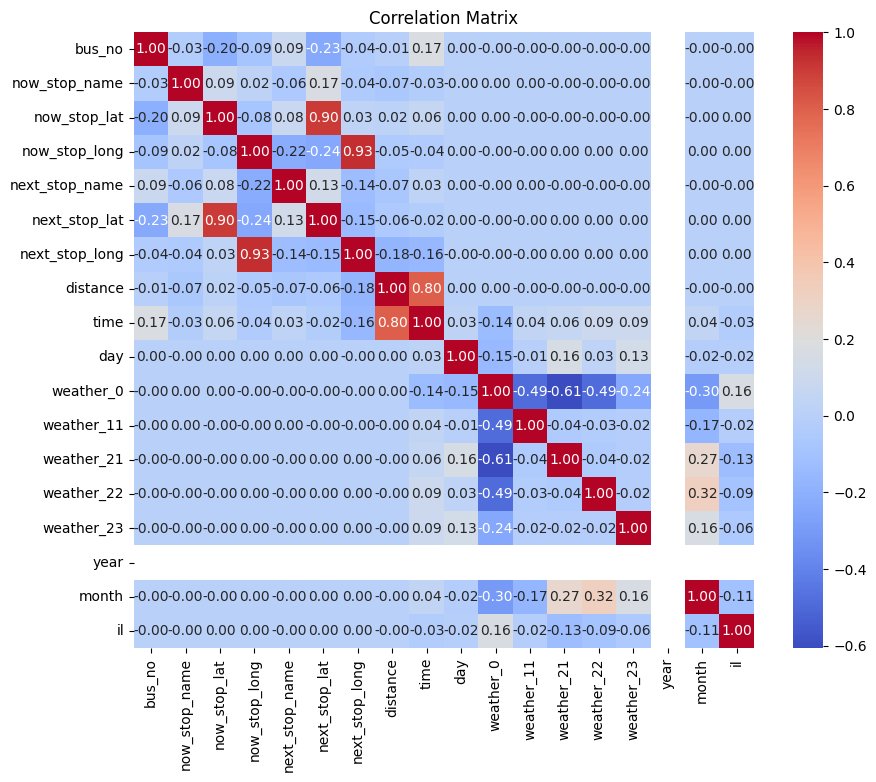

In [43]:
# 상관 관계 찾기
# relevant_columns = ['now_stop_lat', 'now_stop_long', 'next_stop_lat', 'next_stop_long', 'distance', 'weather', 'time']
# correlation_data = df[relevant_columns]

correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
